<a href="https://colab.research.google.com/github/pasquale90/mthesis/blob/master/code/initialcode/1-cnn_esc50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3 different 1D-model_archs trained with raw audio of various SampleRates for 10 epochs each.

In [ ]:
#Import Google_drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#Import libraries
import os
import pandas as pd
import librosa
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm

data_path='/content/gdrive/My Drive/dissertation/ESC-50-master/meta/'
audio_path='/content/gdrive/My Drive/dissertation/ESC-50-master/audio/'

In [ ]:
#Import Dataset
esc50 = pd.read_csv(data_path+'esc50.csv')
audiofiles = os.listdir(audio_path)
print(esc50.shape)
print(len(audiofiles))

(2000, 7)
2000


In [ ]:
mode = 'CNN'
#mode = 'RNN' #under implementation yet...

In [ ]:
#train and fold definition
#make this 5-fold
train = esc50[esc50['fold']!=5]
valid = esc50[esc50['fold']==5]

In [ ]:
def get_raw_waveform(filepath,sr):
  raw, fs=librosa.load(filepath,sr=sr)
  return raw

In [ ]:
class ESC50Data(Dataset): 
  def __init__(self, audiopath, df, in_col, out_col, sr):#(audio_path, train, 'filename', 'category')
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(audiopath,row[in_col])
      raw = get_raw_waveform(file_path,sr=sr)[np.newaxis,...]
      self.data.append(raw)
      #print(raw.shape)
      self.labels.append(self.c2i[row['category']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):#load data on demand
    return self.data[idx], self.labels[idx]

In [ ]:
#model_1 (sr=44100, small batch size)
#load raw waveform
train_data = ESC50Data(audio_path, train, 'filename', 'category', sr=44100)
valid_data = ESC50Data(audio_path, valid, 'filename', 'category', sr=44100)

#iterate data
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=8, shuffle=True)

In [ ]:
#model 2 & 3 (downsampled, large batch size)
train_data = ESC50Data(audio_path, train, 'filename', 'category', sr=16000)
valid_data = ESC50Data(audio_path, valid, 'filename', 'category', sr=16000)

#iterate data
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=True)

In [ ]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
print(device)

cpu


In [ ]:
n_out=((n_in+2*padding-kernel)/stride])+1

In [ ]:
#model 1
class ESC50_MODEL_1_rawcnn(nn.Module):
    def __init__(self,input_shape, num_cats=50):#input_shape=5x16000=80000, batch_size=16, num_cats=50
        super(ESC50_MODEL_1_rawcnn, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=3, stride=3, padding=0),
            nn.BatchNorm1d(128),
            nn.ReLU())
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=3))

        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))

        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
 
        self.conv5 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))

        self.conv6 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3),
            nn.Dropout(0.5))

        self.conv7 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        
        self.conv8 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))

        self.conv9 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        
        self.conv10 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        
        self.conv11 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=2))
        
        self.conv12 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5))

        self.fc = nn.Linear(512, num_cats)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):

        x = x.view(x.shape[0], 1,-1 )
        shape0=x.shape[0]
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.conv12(x) 
        #print(x.shape)
        x = x.view(x.shape[0], x.size(1) * x.size(2))
        #print(x.shape)
        x = self.fc(x)
        return x
        
length = 5 * 4100 #==220500
model = ESC50_MODEL_1_rawcnn(input_shape=(1, length), num_cats=50).to(device)

In [ ]:
#ESC50_MODEL_2_rawcnn - paper based (shallower)
class ESC50_MODEL_2_rawcnn(nn.Module):
    def __init__(self):#input_shape=5x16000=80000, batch_size=16, num_cats=50
        super(ESC50_MODEL_2_rawcnn, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=64, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=8, stride=8, padding=1) 
        self.conv2 = nn.Conv1d(16, 32, kernel_size=32, stride=2, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=8, stride=8, padding=1) 
        self.conv3 = nn.Conv1d(32, 64, kernel_size=16, stride=2, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=8, stride=2, padding=1) 
        self.bn4 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 512)
        self.drop2 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 50)

        
    def forward(self, x):
        x = x.view(x.shape[0], 1,-1 )
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = x.view(x.shape[0], 1, x.size(1) * x.size(2))
        x = self.fc1(self.drop1(x))
        x = self.fc2(self.drop2(x))
        x = F.log_softmax(x, dim = 2)
        x = x.view(x.shape[0], x.size(1)*x.size(2))
        return x
    
model = ESC50_MODEL_2_rawcnn().to(device)

In [ ]:
#ESC50_MODEL_3_rawcnn - paper based (deeper arch)
class ESC50_MODEL_3_rawcnn(nn.Module):
    def __init__(self):#input_shape=5x16000=80000, batch_size=16, num_cats=50
        super(ESC50_MODEL_3_rawcnn, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=64, stride=2, padding=1)#64
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=8, stride=8, padding=1) 
        self.conv2 = nn.Conv1d(16, 32, kernel_size=32, stride=2, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=8, stride=8, padding=1) 
        self.conv3 = nn.Conv1d(32, 64, kernel_size=16, stride=2, padding=1) 
        self.bn3 = nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=8, stride=2, padding=1) 
        self.bn4 = nn.BatchNorm1d(128)
        self.conv5 = nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1) 
        self.bn5 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=4, stride=4, padding=1) 
        self.drop1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(256*9, 512)
        self.drop2 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 50)
        
    def forward(self, x):
        x = x.view(x.shape[0], 1,-1 )
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.pool3(x)
        x = x.view(x.shape[0], 1, x.size(1) * x.size(2))
        x = self.fc1(self.drop1(x))
        x = self.fc2(self.drop2(x))
        x = F.log_softmax(x, dim = 2)
        x = x.view(x.shape[0], x.size(1)*x.size(2))
        return x
        
model = ESC50_MODEL_3_rawcnn().to(device)

In [ ]:
#@title test_shapes
count=0
for i, data in tqdm(enumerate(valid_loader)):#performs a step in the train loop 
  a,b = data
  c=model(a.float()) #= ESC50Model(input_shape=(1,55168), batch_size=16, num_cats=50).to(device)
  count+=1
  print(a.shape)
  #print(torch.max(a[2]))

  print(c.shape)
print(count)

In [ ]:
#CREATE AURPC METRICS
#https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265
#https://github.com/allenai/allennlp/issues/1863
loss_fn = nn.CrossEntropyLoss( )
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)#model.parameters()is a method 
                                                            #to retrieve an iterator over all model’s parameters
                                           #Note:model.state_dict() to get the current values for all parameters
epochs = 10
train_losses = []
valid_losses = []

In [ ]:
def train(model, loss_fn, train_loader, valid_loader,
          epochs, optimizer, train_losses, valid_losses, change_lr):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in tqdm(enumerate(train_loader)):#performs a step in the train loop
      x, y = data
      optimizer.zero_grad()#zero the gradients before updating them
      x = x.to(device, dtype=torch.float32) #init tensor _minibatch(16) of spectograms
      y = y.to(device, dtype=torch.long)  #init tensor _categories' id
      y_hat = model(x) #the equation is the model itself-,model is actually a modeled equation
      loss = loss_fn(y_hat, y)#computing the loss
      loss.backward() #for alleviating the parameters' loss
      batch_losses.append(loss.item()) #here batch_calc is returned
      optimizer.step()#step of the optimizer-updates the parameters/  batch?mini-batch?stohastic? 
    train_losses.append(batch_losses)

    print()
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    print()
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())#allocate the tensor in RAM 
                                  #detatch --> cut computational graph
                                  #cpu --> allocate tensor in RAM
                                  #numpy --> port tensor to numpy
      trace_yhat.append(y_hat.cpu().detach().numpy())
      batch_losses.append(loss.item())

    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)#mean of Trues
    #f1
    #micro,macro auroc
    #acurracy3=get_accuracy(trace_yhat.argmax(axis=1),y,percent=0.1)
    #accuracy2=get_accuracy(trace_y, y, percent=0.1)
  
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy} ')

In [ ]:
#optimizer
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [ ]:
def lr_decay(optimizer, epoch):
  if epoch%20==0:
    new_lr = learning_rate / (10**(epoch//20))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer

# **Results**

In [ ]:
#model 1
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




Epoch - 1 Train-Loss : 3.9166711258888243

Epoch - 1 Valid-Loss : 3.8273364877700806 Valid-Accuracy : 0.0325 




Epoch - 2 Train-Loss : 3.7223169088363646

Epoch - 2 Valid-Loss : 3.7888666725158693 Valid-Accuracy : 0.0725 




Epoch - 3 Train-Loss : 3.597746629714966

Epoch - 3 Valid-Loss : 3.709657588005066 Valid-Accuracy : 0.0875 




Epoch - 4 Train-Loss : 3.5083550775051116

Epoch - 4 Valid-Loss : 3.591156620979309 Valid-Accuracy : 0.105 




Epoch - 5 Train-Loss : 3.3910030269622804

Epoch - 5 Valid-Loss : 3.5425156450271604 Valid-Accuracy : 0.135 




Epoch - 6 Train-Loss : 3.2605701220035552

Epoch - 6 Valid-Loss : 3.4566383838653563 Valid-Accuracy : 0.1425 




Epoch - 7 Train-Loss : 3.202138890028

Epoch - 7 Valid-Loss : 3.4228446292877197 Valid-Accuracy : 0.16 




Epoch - 8 Train-Loss : 3.140589373111725

Epoch - 8 Valid-Loss : 3.3527463150024412 Valid-Accuracy : 0.1775 




Epoch - 9 Train-Loss : 3.061610978841782

Epoch - 9 Valid-Loss : 3.313121395111084 Valid-Accuracy : 0.2025 




Epoch - 10 Train-Loss : 3.0019131648540496

Epoch - 10 Valid-Loss : 3.3295891666412354 Valid-Accuracy : 0.165 



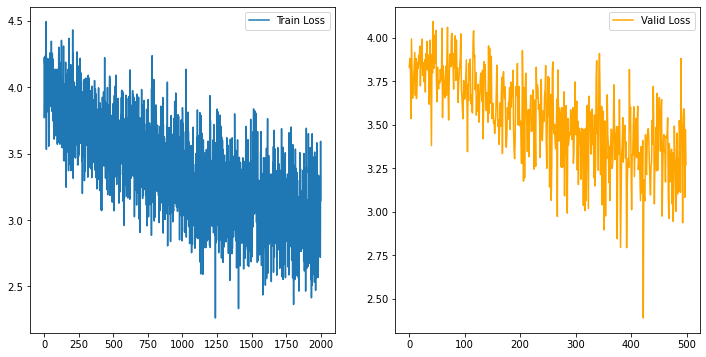

In [ ]:
#model 1
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

In [ ]:
#model 2
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




Epoch - 1 Train-Loss : 3.8542044896345873

Epoch - 1 Valid-Loss : 3.9150174856185913 Valid-Accuracy : 0.02 




Epoch - 2 Train-Loss : 3.674804760859563

Epoch - 2 Valid-Loss : 3.8780770301818848 Valid-Accuracy : 0.0225 




Epoch - 3 Train-Loss : 3.5165989582355204

Epoch - 3 Valid-Loss : 3.773086905479431 Valid-Accuracy : 0.04 




Epoch - 4 Train-Loss : 3.3974911983196554

Epoch - 4 Valid-Loss : 3.712636888027191 Valid-Accuracy : 0.085 




Epoch - 5 Train-Loss : 3.283340545801016

Epoch - 5 Valid-Loss : 3.5583935379981995 Valid-Accuracy : 0.1075 




Epoch - 6 Train-Loss : 3.175348997116089

Epoch - 6 Valid-Loss : 3.5451278686523438 Valid-Accuracy : 0.1375 




Epoch - 7 Train-Loss : 3.0768081224881687

Epoch - 7 Valid-Loss : 3.4499120712280273 Valid-Accuracy : 0.135 




Epoch - 8 Train-Loss : 2.9708624436305118

Epoch - 8 Valid-Loss : 3.359269678592682 Valid-Accuracy : 0.1425 




Epoch - 9 Train-Loss : 2.883827429551345

Epoch - 9 Valid-Loss : 3.316186249256134 Valid-Accuracy : 0.1525 




Epoch - 10 Train-Loss : 2.7990008684305043

Epoch - 10 Valid-Loss : 3.2310463190078735 Valid-Accuracy : 0.16 



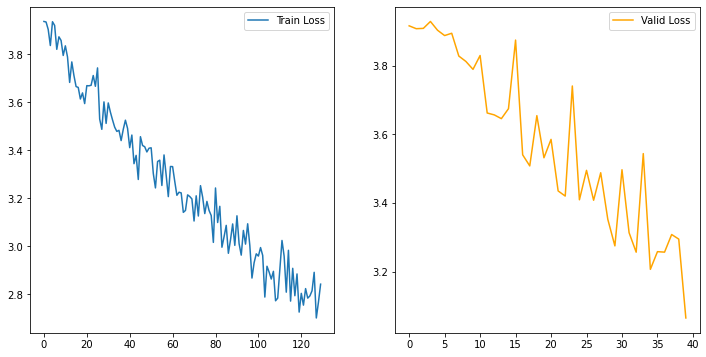

In [ ]:
#model 2
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

In [ ]:
#model 3
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




Epoch - 1 Train-Loss : 4.05995068183312

Epoch - 1 Valid-Loss : 3.912225306034088 Valid-Accuracy : 0.02 




Epoch - 2 Train-Loss : 4.066298136344323

Epoch - 2 Valid-Loss : 3.9164665937423706 Valid-Accuracy : 0.025 




Epoch - 3 Train-Loss : 4.060858689821684

Epoch - 3 Valid-Loss : 3.9298471212387085 Valid-Accuracy : 0.02 




Epoch - 4 Train-Loss : 4.054422506919274

Epoch - 4 Valid-Loss : 3.9653497338294983 Valid-Accuracy : 0.015 




Epoch - 5 Train-Loss : 4.047547853910006

Epoch - 5 Valid-Loss : 3.9822123050689697 Valid-Accuracy : 0.0175 




Epoch - 6 Train-Loss : 4.055717798379751

Epoch - 6 Valid-Loss : 4.00613671541214 Valid-Accuracy : 0.0125 




Epoch - 7 Train-Loss : 4.055691187198345

Epoch - 7 Valid-Loss : 4.04180908203125 Valid-Accuracy : 0.0125 




Epoch - 8 Train-Loss : 4.045794211901152

Epoch - 8 Valid-Loss : 4.0123565793037415 Valid-Accuracy : 0.0125 




Epoch - 9 Train-Loss : 4.0538943730867825

Epoch - 9 Valid-Loss : 4.031297445297241 Valid-Accuracy : 0.01 




Epoch - 10 Train-Loss : 4.047039692218487

Epoch - 10 Valid-Loss : 4.030157685279846 Valid-Accuracy : 0.0125 



In [ ]:
#model 3
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

#forgot to graph before values were lost....

In [ ]:
#model1
Epoch - 1 Train-Loss : 3.9166711258888243
Epoch - 1 Valid-Loss : 3.8273364877700806 Valid-Accuracy : 0.0325 

Epoch - 2 Train-Loss : 3.7223169088363646
Epoch - 2 Valid-Loss : 3.7888666725158693 Valid-Accuracy : 0.0725 

Epoch - 3 Train-Loss : 3.597746629714966
Epoch - 3 Valid-Loss : 3.709657588005066 Valid-Accuracy : 0.0875 

Epoch - 4 Train-Loss : 3.5083550775051116
Epoch - 4 Valid-Loss : 3.591156620979309 Valid-Accuracy : 0.105 

Epoch - 5 Train-Loss : 3.3910030269622804
Epoch - 5 Valid-Loss : 3.5425156450271604 Valid-Accuracy : 0.135 

Epoch - 6 Train-Loss : 3.2605701220035552
Epoch - 6 Valid-Loss : 3.4566383838653563 Valid-Accuracy : 0.1425 

Epoch - 7 Train-Loss : 3.202138890028
Epoch - 7 Valid-Loss : 3.4228446292877197 Valid-Accuracy : 0.16 

Epoch - 8 Train-Loss : 3.140589373111725
Epoch - 8 Valid-Loss : 3.3527463150024412 Valid-Accuracy : 0.1775 

Epoch - 9 Train-Loss : 3.061610978841782
Epoch - 9 Valid-Loss : 3.313121395111084 Valid-Accuracy : 0.2025 

Epoch - 10 Train-Loss : 3.0019131648540496
Epoch - 10 Valid-Loss : 3.3295891666412354 Valid-Accuracy : 0.165 


#model2
Epoch - 1 Train-Loss : 3.8542044896345873
Epoch - 1 Valid-Loss : 3.9150174856185913 Valid-Accuracy : 0.02 

Epoch - 2 Train-Loss : 3.674804760859563
Epoch - 2 Valid-Loss : 3.8780770301818848 Valid-Accuracy : 0.0225 

Epoch - 3 Train-Loss : 3.5165989582355204
Epoch - 3 Valid-Loss : 3.773086905479431 Valid-Accuracy : 0.04 

Epoch - 4 Train-Loss : 3.3974911983196554
Epoch - 4 Valid-Loss : 3.712636888027191 Valid-Accuracy : 0.085 

Epoch - 5 Train-Loss : 3.283340545801016
Epoch - 5 Valid-Loss : 3.5583935379981995 Valid-Accuracy : 0.1075 

Epoch - 6 Train-Loss : 3.175348997116089
Epoch - 6 Valid-Loss : 3.5451278686523438 Valid-Accuracy : 0.1375 

Epoch - 7 Train-Loss : 3.0768081224881687
Epoch - 7 Valid-Loss : 3.4499120712280273 Valid-Accuracy : 0.135 

Epoch - 8 Train-Loss : 2.9708624436305118
Epoch - 8 Valid-Loss : 3.359269678592682 Valid-Accuracy : 0.1425 

Epoch - 9 Train-Loss : 2.883827429551345
Epoch - 9 Valid-Loss : 3.316186249256134 Valid-Accuracy : 0.1525 

Epoch - 10 Train-Loss : 2.7990008684305043
Epoch - 10 Valid-Loss : 3.2310463190078735 Valid-Accuracy : 0.16 

#model3 (...graph?)
Epoch - 1 Train-Loss : 4.05995068183312
Epoch - 1 Valid-Loss : 3.912225306034088 Valid-Accuracy : 0.02 

Epoch - 2 Train-Loss : 4.066298136344323
Epoch - 2 Valid-Loss : 3.9164665937423706 Valid-Accuracy : 0.025 

Epoch - 3 Train-Loss : 4.060858689821684
Epoch - 3 Valid-Loss : 3.9298471212387085 Valid-Accuracy : 0.02 

Epoch - 4 Train-Loss : 4.054422506919274
Epoch - 4 Valid-Loss : 3.9653497338294983 Valid-Accuracy : 0.015 

Epoch - 5 Train-Loss : 4.047547853910006
Epoch - 5 Valid-Loss : 3.9822123050689697 Valid-Accuracy : 0.0175 

Epoch - 6 Train-Loss : 4.055717798379751
Epoch - 6 Valid-Loss : 4.00613671541214 Valid-Accuracy : 0.0125 

Epoch - 7 Train-Loss : 4.055691187198345
Epoch - 7 Valid-Loss : 4.04180908203125 Valid-Accuracy : 0.0125 

Epoch - 8 Train-Loss : 4.045794211901152
Epoch - 8 Valid-Loss : 4.0123565793037415 Valid-Accuracy : 0.0125 

Epoch - 9 Train-Loss : 4.0538943730867825
Epoch - 9 Valid-Loss : 4.031297445297241 Valid-Accuracy : 0.01 

Epoch - 10 Train-Loss : 4.047039692218487
Epoch - 10 Valid-Loss : 4.030157685279846 Valid-Accuracy : 0.0125 

In [ ]:
with open('/content/gdrive/My Drive/dissertation/models/111.ESC50_MODEL_1_rawcnn.pth','wb') as f:
  torch.save(ESC50_MODEL_1_rawcnn, f)

In [ ]:
import pickle
with open('/content/gdrive/My Drive/dissertation/models/data/111.esc50_raw_44100.pkl','wb') as f:
  pickle.dump(train_data.i2c, f)

In [ ]:
#metrics
    Count of the class in the ground truth target data;
    Count of the class in the predictions;
    Count how many times the class was correctly predicted.

Let's assume you want to compute F1 score for the class with index 0 in your softmax. In every batch, you can do:

predicted_classes = torch.argmax(y_pred, dim=1) == 0
target_classes = self.get_vector(y_batch)
target_true += torch.sum(target_classes == 0).float()
predicted_true += torch.sum(predicted_classes).float()
correct_true += torch.sum(
predicted_classes == target_classes * predicted_classes == 0).float()